In [1]:
import PIL
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import text
from astropy.visualization import hist
from astropy.visualization.hist import hist as fancyhist #to have scott and freedman-diaconis binsize
from __future__ import print_function

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import stats, interpolate

#from astroML import stats as astroMLstatsπ
from astroML import stats as astroMLstats
from astroML.density_estimation import EmpiricalDistribution

from tqdm.notebook import tqdm

from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Black-hole irreducible mass

For a black hole of mass $m$ and spin $\chi \in [0,1]$ we have that the irreducible mass $M_{irr}$ is:

$$M_{irr} = M\sqrt{\frac{1 + \sqrt{1-\chi^2}}{2}}$$

where

&#10148; Spin distribution: pdf($\chi$) = $Uniform(\chi \in [0,1])$

&#10148; Mass distribution:  pdf(m) = $G(\mu=1,\sigma=0.02)$

In [2]:
N = 1000
mu = 1
sigma = 0.02

In [3]:
spin = np.random.uniform(0,1,N)
mass = np.random.normal(mu, sigma, N)

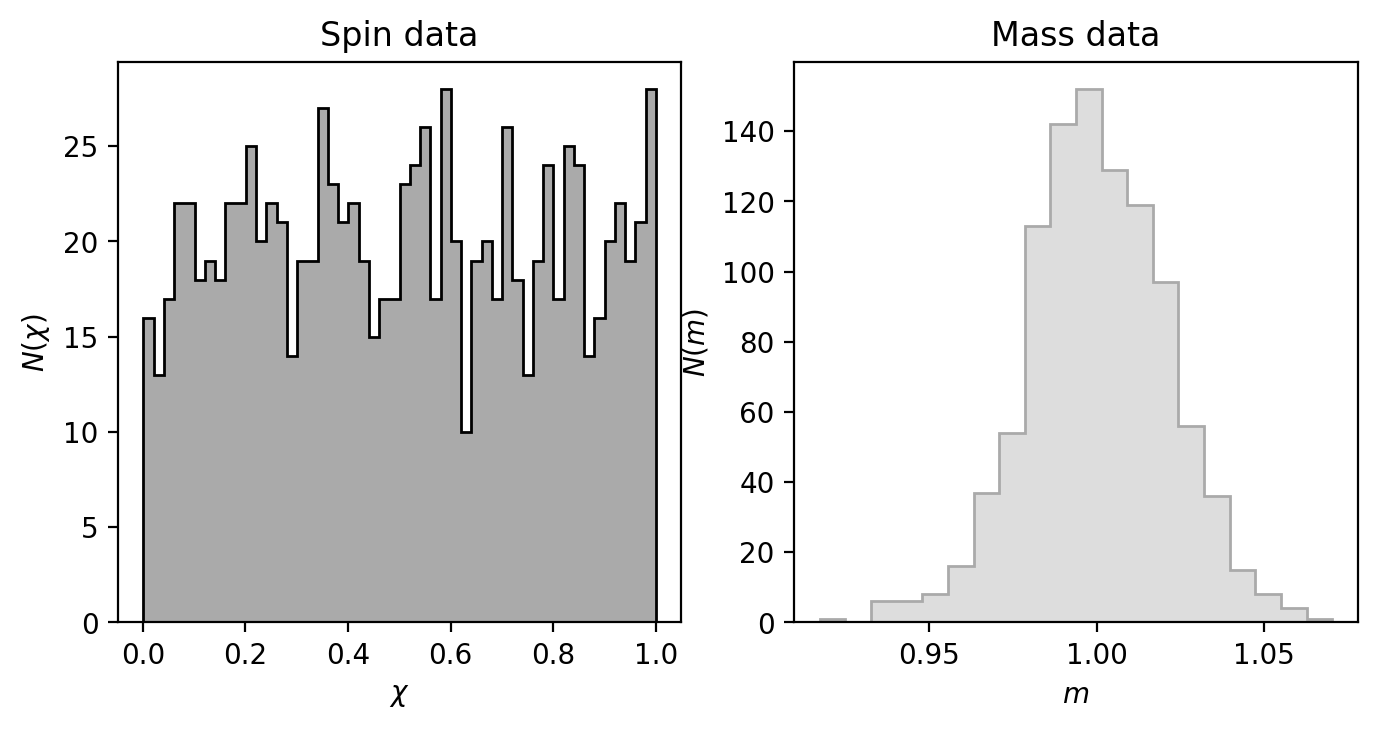

In [4]:
fig = plt.figure(figsize=(8, 8))
#fig.subplots_adjust(hspace=0.3, left=0.1, right=0.95,bottom=0.08, top=0.92, wspace=0.3)

# plot a histogram of the input
ax = fig.add_subplot(221)
hist(spin, bins=50, ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA', label='Input spin distribution')
#ax.set_ylim(0, 350)
ax.set_title('Spin data')
ax.set_xlabel('$\chi$')
ax.set_ylabel('$N(\chi)$')
#plt.legend()

ax = fig.add_subplot(222)
hist(mass, bins=20, ax=ax,
     histtype='stepfilled', density=False,
     ec='#AAAAAA', fc='#DDDDDD',
     label='Input mass data')
ax.set_title('Mass data')
ax.set_xlabel('$m$')
ax.set_ylabel('$N(m)$')
#plt.legend(loc='center right')

plt.show()

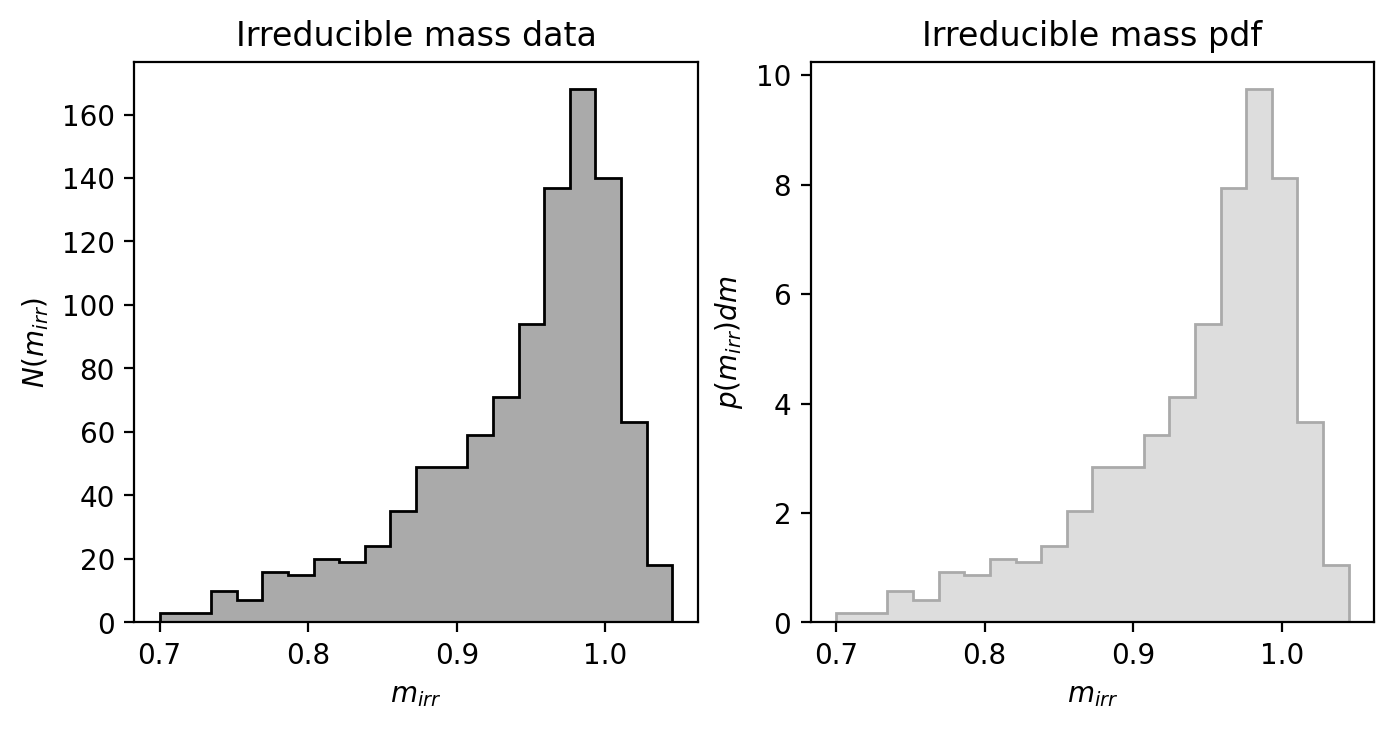

In [5]:
mass_irr = mass*np.sqrt((1 + np.sqrt(1 - spin**2))/2)

fig = plt.figure(figsize=(8, 8))
#fig.subplots_adjust(hspace=0.3, left=0.1, right=0.95,bottom=0.08, top=0.92, wspace=0.3)

# plot a histogram of the input
ax = fig.add_subplot(221)
m_counts, m_bins, m_ = hist(mass_irr, bins=20, ax=ax,
     histtype='stepfilled', ec='k', fc='#AAAAAA', label='Irreducible mass data')
#ax.set_ylim(0, 350)
ax.set_title('Irreducible mass data')
ax.set_xlabel('$m_{irr}$')
ax.set_ylabel('$N(m_{irr})$')
#plt.legend()

ax = fig.add_subplot(222)
hist(mass_irr, bins=20, ax=ax,histtype='stepfilled', density=True,
     ec='#AAAAAA', fc='#DDDDDD',label='Irreducible mass data')
ax.set_title('Irreducible mass pdf')
ax.set_xlabel('$m_{irr}$')
ax.set_ylabel('$p(m_{irr})dm$')
#plt.legend(loc='center right')

plt.show()

##### spin-off : build an empirical cumulative distribution function ECDF

In [6]:
ecdf = np.column_stack((m_bins[:-1], m_counts))
ecdf_sort = sorted(ecdf,key=lambda x: x[0])
x = np.array(ecdf_sort)[:,0]
y = np.array(ecdf_sort)[:,1]
y_tot = np.sum(y)

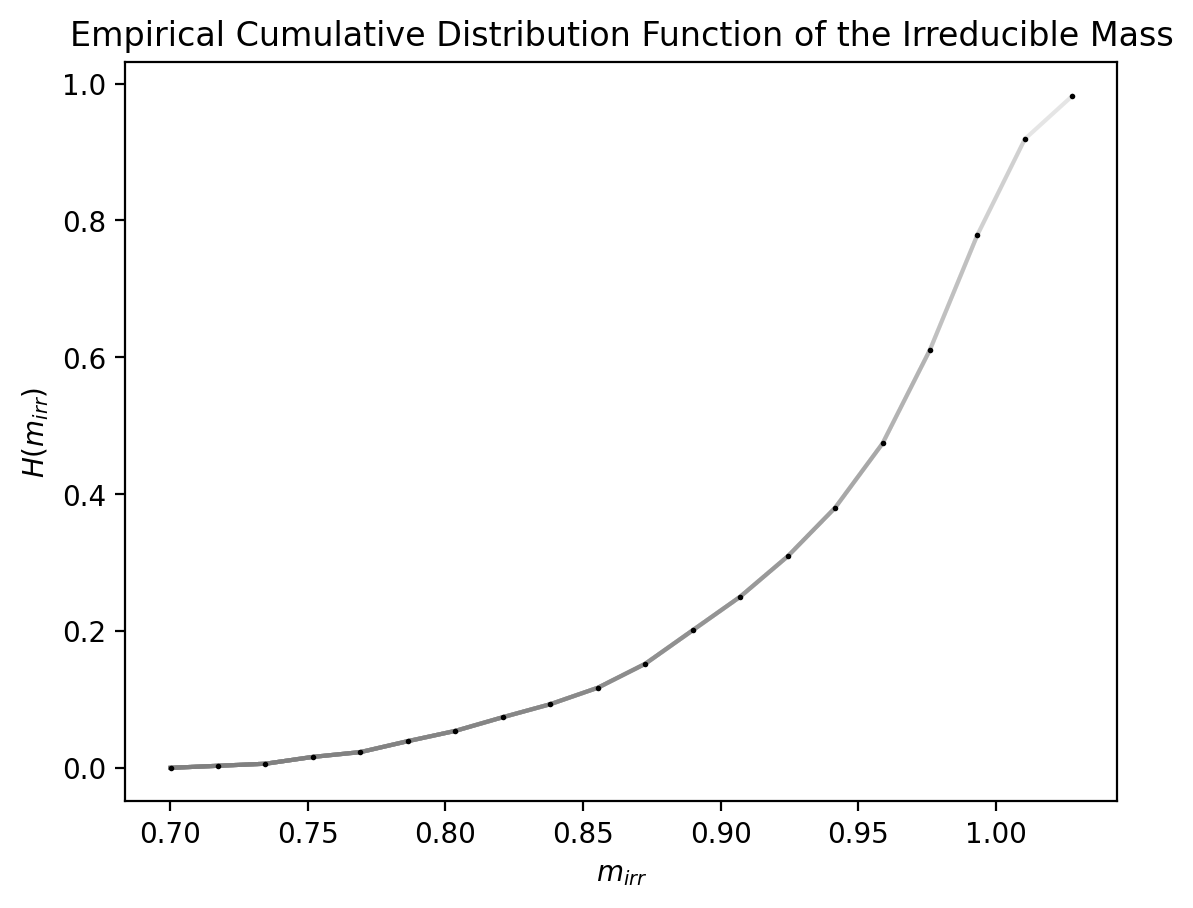

In [7]:
x_i = []
y_i = []

for i in range(ecdf.shape[0]):
    plt.scatter(x[i], np.sum(y[:i])/y_tot,s=1,color='k', zorder=1)
    x_i.append(x[i])
    y_i.append(np.sum(y[:i])/y_tot)
    plt.plot(x_i,y_i, color='gray', zorder=0, alpha=0.2)
    
plt.xlabel("$m_{irr}$")
plt.ylabel("$H(m_{irr})$")
plt.title("Empirical Cumulative Distribution Function of the Irreducible Mass")
plt.show()

## And now.. fun with binwidths!
Let's plot the distribution in histograms with different binsize, according "Scott's rule", "Freedman-Diaconis rule" ecc..

In [8]:
#compute sigmaG for Freedman-Diaconis binsize
sigmaG = astroMLstats.sigmaG(mass_irr)
binsize = 2.7*sigmaG/(N**(1/3))
binsG = np.append(np.arange(start=min(mass_irr), stop=max(mass_irr), step=binsize) , max(mass_irr)) #Complete
print("sigmaG is: ", sigmaG, "so the bin size is: ",binsize)

sigmaG is:  0.061233035273124625 so the bin size is:  0.016532919523743653


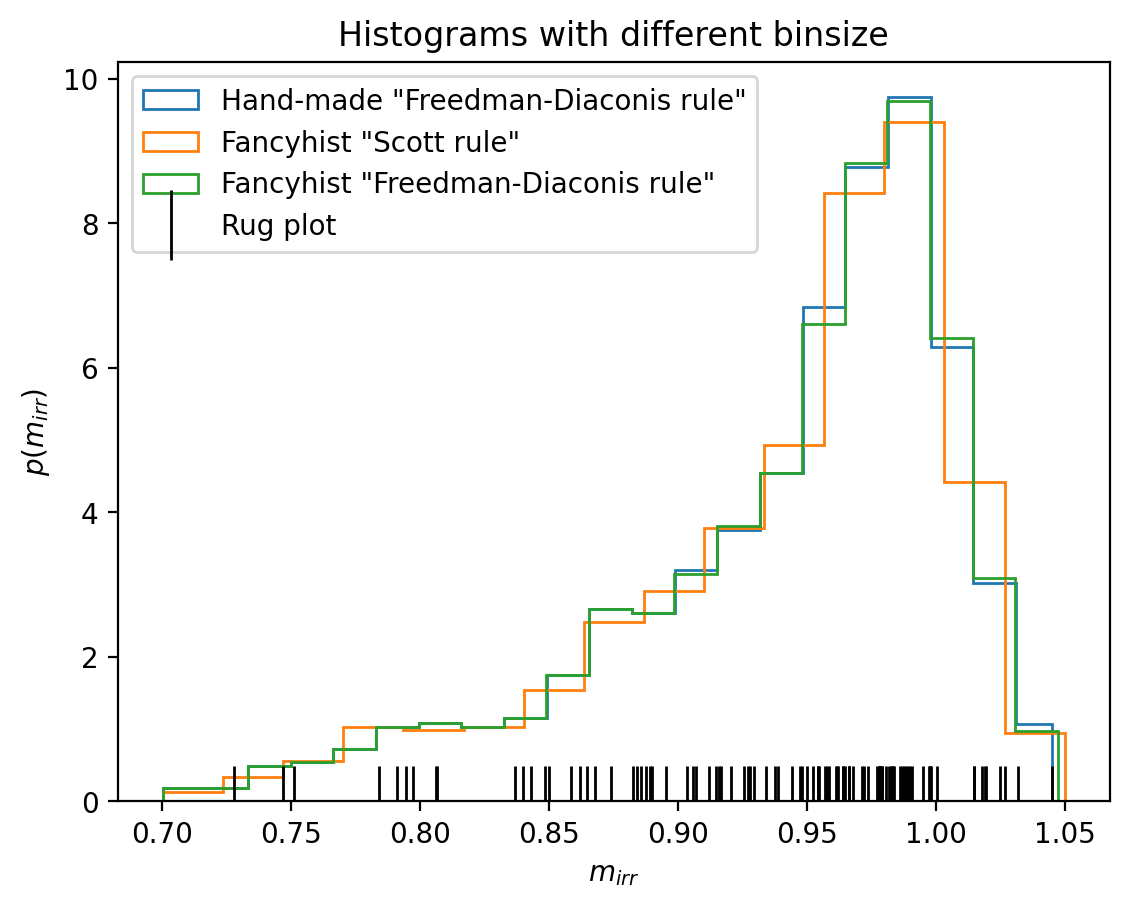

In [9]:
_ = plt.hist(mass_irr, bins=binsG, density=True, histtype="step", label='Hand-made "Freedman-Diaconis rule"') 
_ = fancyhist(mass_irr, bins="scott", histtype="step",density=True, label='Fancyhist "Scott rule"')
_ = fancyhist(mass_irr, bins="freedman", histtype="step",density=True, label='Fancyhist "Freedman-Diaconis rule"')
plt.plot(mass_irr[:100], 0*mass_irr[:100], '|', color='k', markersize=25, label='Rug plot') 

plt.title("Histograms with different binsize")
plt.xlabel('$m_{irr}$')
plt.ylabel('$p(m_{irr})$')
plt.legend(loc='upper left')
plt.show()

## KDE
Perform a kde to plot the right histogram density with individual gaussians kernel https://en.wikipedia.org/wiki/Kernel_density_estimation \
A KDE performs a density estimation by considering all the points in the distribution as individual distributions themselves: the kernel can be linear, triangular, gaussian, epanechnikov..

For Gaussian kernel, the indivual pdf($M_{irr,i}$) of each data point are centered in $\mu = M_{irr,i}$ with  $\sigma = $ binwidth

In [10]:
def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

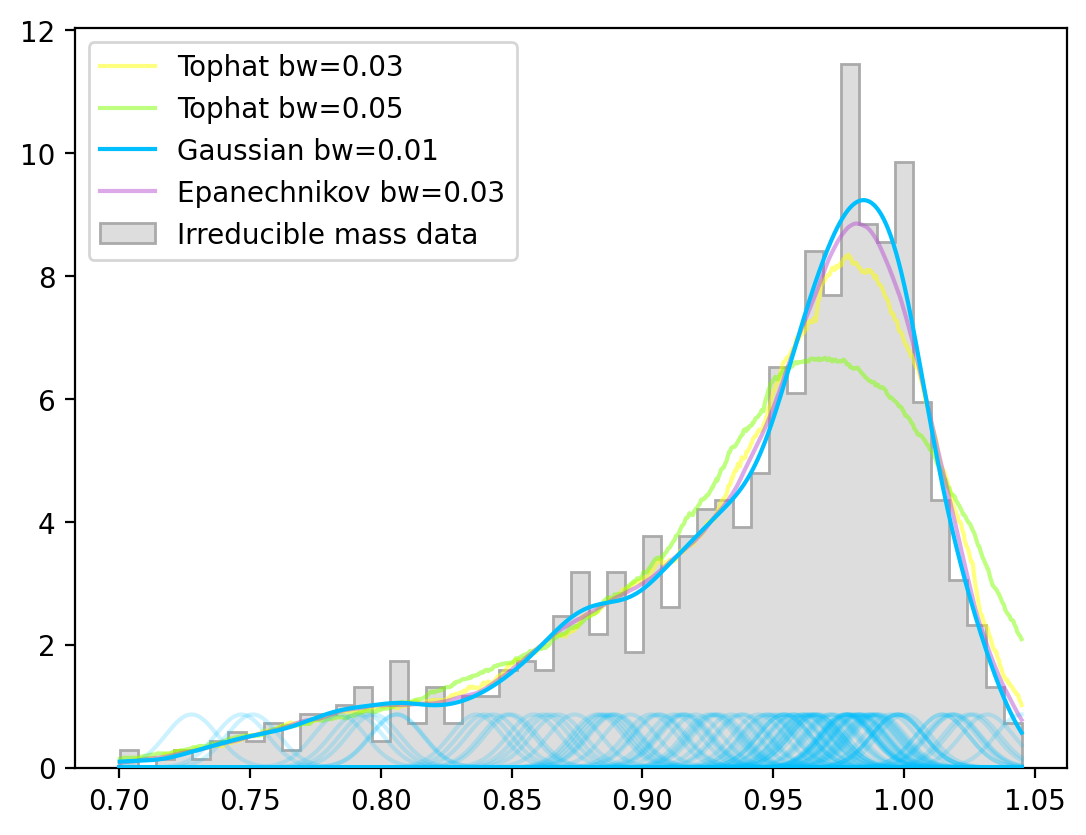

In [11]:
xgrid = np.linspace(min(mass_irr),max(mass_irr),1000)

bandwidth1 = 0.1
bandwidth2 = 0.05
bandwidth3 = 0.03
bandwidth4 = 0.01

PDFtophat = kde_sklearn(mass_irr,bandwidth=bandwidth3,kernel="tophat")
plt.plot(xgrid,PDFtophat, color='yellow', label='Tophat bw='f'{bandwidth3}', alpha=0.5) 

PDFtophat = kde_sklearn(mass_irr,bandwidth=bandwidth2,kernel="tophat")
plt.plot(xgrid,PDFtophat, color='chartreuse', label='Tophat bw='f'{bandwidth2}',alpha=0.5) 

PDFgaus = kde_sklearn(mass_irr,bandwidth=bandwidth4,kernel="gaussian") 
plt.plot(xgrid,PDFgaus, color='deepskyblue', label='Gaussian bw='f'{bandwidth4}',zorder=7,alpha=1) 

#plot gaussian individual kernels
for i in mass_irr[:100]:
    plt.plot(xgrid, norm.pdf(xgrid, i, bandwidth4)/max(PDFgaus)*0.2, color='deepskyblue',alpha=0.2,zorder=6)

PDFepa = kde_sklearn(mass_irr,bandwidth=bandwidth3,kernel="epanechnikov") 
plt.plot(xgrid,PDFepa, color='mediumorchid', label='Epanechnikov bw='f'{bandwidth3}',alpha=0.5) 

plt.hist(mass_irr, bins=50, histtype='stepfilled', density=True,
     ec='#AAAAAA', fc='#DDDDDD',label='Irreducible mass data')

plt.legend()
plt.show()

## KS test
Now let's compute KS test comparing $M_{irr}$ with $f$ and $M$.\
Let $\sigma$ variate between $\sigma \in [10^{-4}, 10^2]$ and compute the distance $D$ and the p-value $p$:

$$ D(M_{irr},M) = max|M_{irr}(\sigma) - M(\sigma)| \rightarrow p_M  $$ 
$$ D(M_{irr},f) = max|M_{irr}(\sigma) - f(\sigma)| \rightarrow p_f $$

When the distance $ D \rightarrow 0$ the to distribution are similar!\
Whereas when the p-value $\rightarrow 0$ the hypotesys of the two distribution being similar has to be rejected

In [12]:
sigmas = np.logspace(-4,2)
n = np.arange(0,len(sigmas))
mass_i = np.zeros((len(sigmas),N))
mass_irr_i = np.zeros((len(sigmas),N))
f = np.zeros((len(sigmas),N))
ks_tests_f = np.zeros(len(sigmas))
ks_tests_M = np.zeros(len(sigmas))

In [13]:
for i in n:
    mass_i[i,:] = np.random.normal(mu, sigmas[i], N)
    mass_irr_i[i,:] = mass_i[i,:]*np.sqrt((1 + np.sqrt(1 - spin**2))/2)

    f[i,:] = mass_irr_i[i,:]/mass_i[i,:]
    
    ks_tests_f[i] = stats.kstest(mass_irr_i[i,:],f[i,:])[1]
    ks_tests_M[i] = stats.kstest(mass_irr_i[i,:],mass_i[i,:])[1]

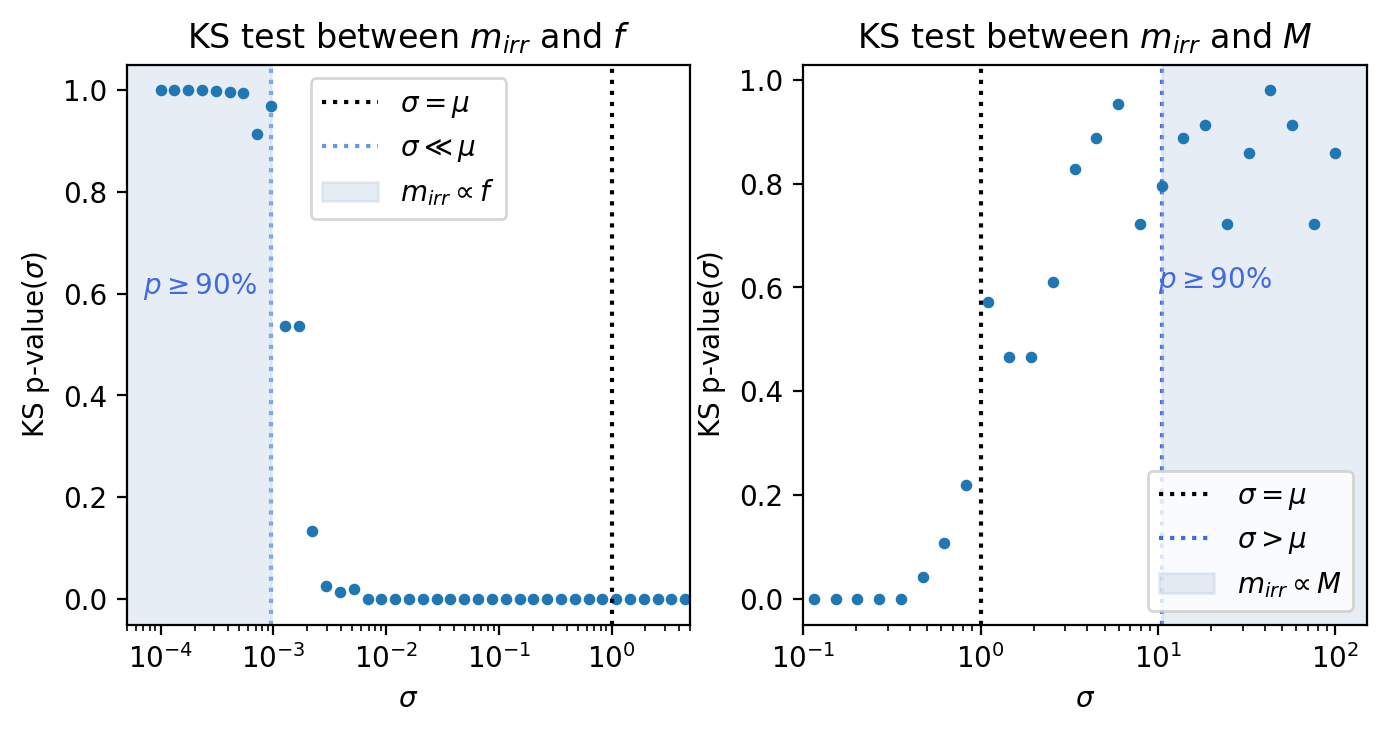

In [14]:
fig = plt.figure(figsize=(8, 8))

x1 = sigmas[len(ks_tests_f[ks_tests_f>0.9])-1]
x2 = sigmas[len(sigmas)-len(ks_tests_M[ks_tests_M > 0.8])]

# plot a histogram of the input
ax = fig.add_subplot(221)
ax.scatter(sigmas,ks_tests_f, s=10)
plt.axvline(mu,color='k',linestyle='dotted', label='$\sigma = \mu$')
plt.axvline(x1,color='cornflowerblue',linestyle='dotted', label='$\sigma \ll \mu$',zorder=0)
ax.axvspan(mu-sigmas[len(sigmas)-1], x1, alpha=0.3, color='lightsteelblue', label='$m_{irr} \propto f$',zorder=0)
plt.text(7e-5,0.6, '$p\geq90\%$', color='royalblue')
ax.set_xlim(5e-5,5)
#ax.set_ylim(-0.1, 1)
ax.set_xscale('log')
ax.set_title('KS test between $m_{irr}$ and $f$')
ax.set_xlabel('$\sigma$')
ax.set_ylabel('KS p-value($\sigma$)')
ax.legend(loc='upper center')

ax = fig.add_subplot(222)
ax.scatter(sigmas,ks_tests_M, s=10)
plt.axvline(mu,color='k',linestyle='dotted', label='$\sigma = \mu$')
plt.axvline(x2,color='royalblue',linestyle='dotted',zorder=0, label='$\sigma > \mu$')
ax.axvspan(x2, mu+sigmas[len(sigmas)-1]+50, alpha=0.3, color='lightsteelblue', label='$m_{irr} \propto M$',zorder=0)
plt.text(10,0.6, '$p\geq90\%$', color='royalblue')
ax.set_xlim(0.1,150)
#ax.set_ylim(-0.01, 1)
ax.set_xscale('log')
ax.set_title('KS test between $m_{irr}$ and $M$')
ax.set_xlabel('$\sigma$')
ax.set_ylabel('KS p-value($\sigma$)')
ax.legend(loc='lower right')

plt.show()

In [15]:
ks_tests_f_stat = np.zeros(len(sigmas))
ks_tests_M_stat = np.zeros(len(sigmas))

for i in n:
    
    ks_tests_f_stat[i] = stats.kstest(mass_irr_i[i,:],f[i,:])[0]
    ks_tests_M_stat[i] = stats.kstest(mass_irr_i[i,:],mass_i[i,:])[0]

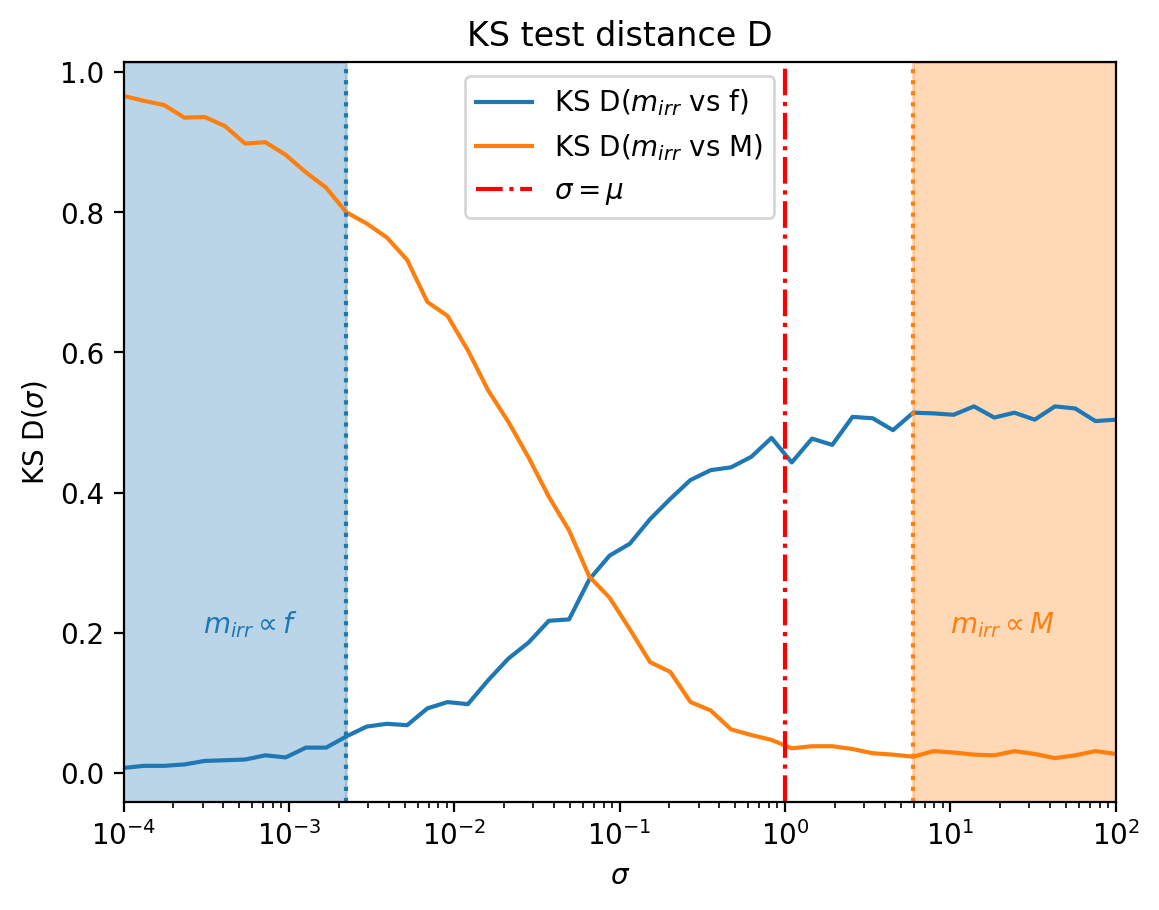

In [16]:
x3 = sigmas[len(ks_tests_f_stat[ks_tests_f_stat < 0.05])]
x4 = sigmas[len(sigmas)-len(ks_tests_M_stat[ks_tests_f_stat<0.05])]

plt.plot(sigmas,ks_tests_f_stat,label='KS D($m_{irr}$ vs f)')
plt.plot(sigmas,ks_tests_M_stat, label='KS D($m_{irr}$ vs M)')

plt.axvline(1,color='r', linestyle='dashdot', label='$\sigma = \mu$')
plt.axvline(x3,color='tab:blue', linestyle='dotted')
plt.axvspan(mu-sigmas[len(sigmas)-1], x3, alpha=0.3, color='tab:blue',zorder=0)
plt.text(3e-4,0.2, '$m_{irr} \propto f$', color='tab:blue', zorder=3)

plt.axvline(x4, color='tab:orange', linestyle='dotted')
plt.axvspan(x4, sigmas[len(sigmas)-1], alpha=0.3, color='tab:orange',zorder=0)
plt.text(10,0.2, '$m_{irr} \propto M$', color='tab:orange', zorder=3)
plt.title('KS test distance D')
plt.xlabel('$\sigma$')
plt.ylabel('KS D($\sigma$)')
plt.xlim(1e-4,1e2)
plt.semilogx()
plt.legend();

I have found that:

&#10148; for $\sigma \ll \mu:$ KS($M_{irr}$ vs $f$) gives:
$\begin{cases}
D \longrightarrow 0 \\
p_f \geq 90\%
\end{cases}$ $\Longrightarrow$ pdf($M_{irr}$) $\propto$ pdf($f$)


&#10148; for $\sigma > \mu:$ KS($M_{irr}$ vs $M$) gives:
$\begin{cases}
D \longrightarrow 0 \\
p_M \geq 90\%
\end{cases}$ $\Longrightarrow$ pdf($M_{irr}$) $\propto$ pdf($M$)

## Semi-analitical distribution for irreducible mass
Compute semi-analitical pdf($m_{irr}$) to see if it matches KDE results.\
I choose $\mu=1, \sigma=0.02$

It is possible to compute the analitical pdf($f$) knowing pdf($\chi$) = 1:

$$ f = \frac{M_{irr}}{M} = {\sqrt\frac{1 + \sqrt{1 - \chi^2}}{2}} = f(\chi) $$

From the trasformation of probabilities:

$$ pdf(f(\chi)) = \bigg|\frac{df}{d\chi}\bigg|^{-1}pdf(\chi) $$

that boils down to compute the derivative!

$$ \frac{df}{d\chi} = \frac{1}{2} \chi \frac{1}{\sqrt{\frac{1+ \sqrt{1-\chi^2}}{2}}}  \frac{1}{\sqrt{1-\chi^2}}$$

since $\chi = \sqrt{1-\sqrt{2f^2 - 1}}$
$$\longrightarrow \frac{df}{d\chi} = \frac{1}{2}\sqrt{1-\sqrt{2f^2 - 1}} \frac{1}{f(2f^2 - 1)}$$

$$\Longrightarrow pdf(f) = \bigg|\frac{df}{d\chi}\bigg|^{-1} \cdot 1 = 2f \frac{2f^2 - 1}{\sqrt{1 - \sqrt{2f^2-1}}} $$

And

$$ pdf(M) = \frac{1}{\sigma\sqrt{2\pi}}\text{exp} \bigg\{ {\frac{-( M - \mu )^2}{2\sigma^2}} \bigg\}$$



To compute the pdf($M_{irr}$) it is now necessary a theorem that says: if I have two IID samples X=$f$,Y=$M$ and their distributions $f_X$ = pdf($f$) and $f_Y$ = pdf($M$), then their product Z = XY will have a pdf:

$$ f_Z = pdf(M_{irr}) = \int {f_X(x) f_Y\bigg(\frac{z}{y}\bigg) \frac{dx}{|x|}} = \int{ pdf(f)pdf\bigg(\frac{M_{irr}}{f} \bigg) \frac{df}{|f|} }$$

Finally, to find pdf($M_{irr}$) I "simply" have to solve this integral:

$$pdf(M_{irr}) = \frac{2}{\sigma\sqrt{2\pi}} \int_{\frac{1}{\sqrt{2}}}^{1}{ \frac{2f^2 -1}{\sqrt{1-\sqrt{2f^2 -1}}}e^\frac{-\big( \frac{M_{irr}}{f} - \mu \big)^2}{2\sigma^2}df } $$


Let's do it numerically!\
The $\texttt{scipy.integrate.quad}$ method computes the integral of a function $g(x)$ by approximating it to:

$$ \int_{a}^{b}{g(x)dx} \sim \sum_{i=0}^{n}{\omega_i g(x_i)}$$

where $g(x_i$) is evaluated recursively in $x_i$:

$$ x_i = a + \frac{b-a}{n}i $$

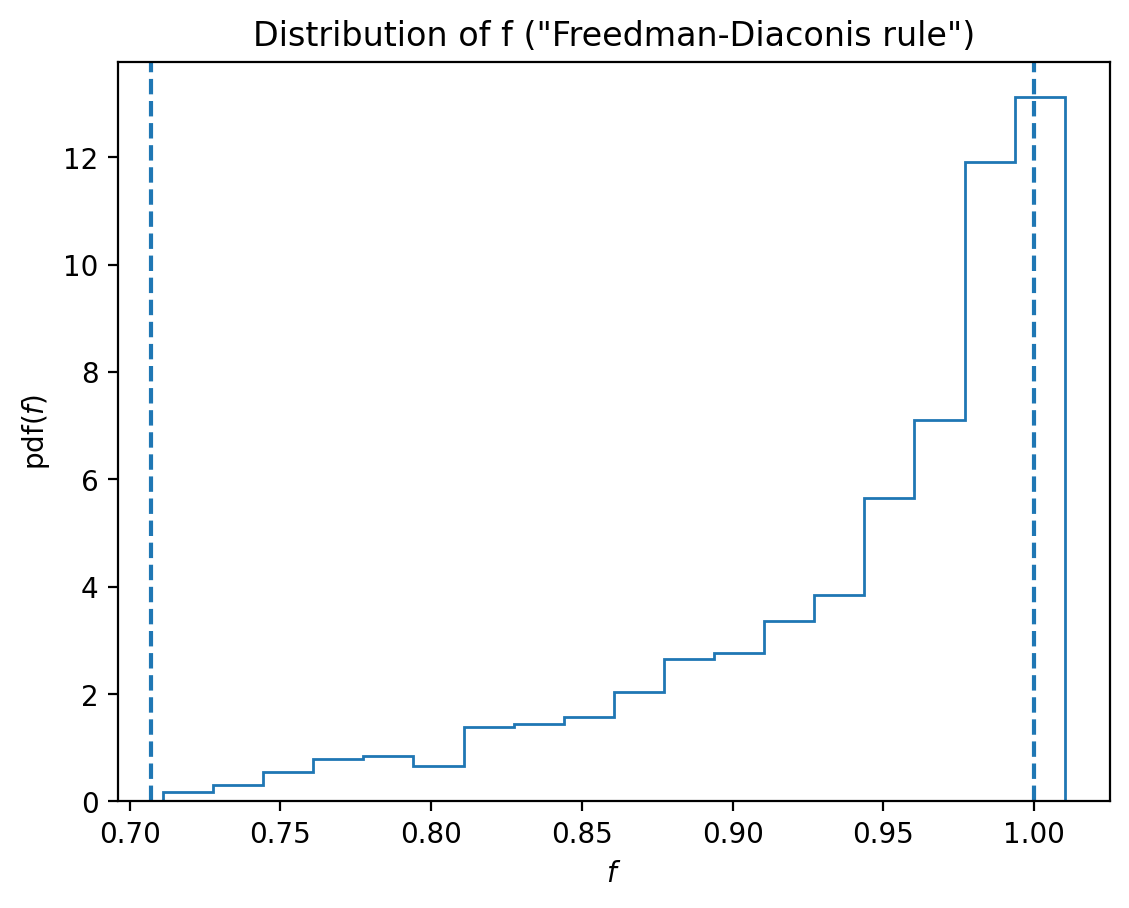

In [17]:
f_sigma = mass_irr/mass

f_ = fancyhist(f_sigma, bins="freedman", histtype="step",density=True, label='Fancyhist "Freedman-Diaconis rule"')
    
plt.axvline(1, color='tab:blue', linestyle='dashed')
plt.axvline(1/2**0.5, color='tab:blue', linestyle='dashed')

plt.title('Distribution of f ("Freedman-Diaconis rule")')
plt.xlabel('$f$')
plt.ylabel('pdf($f$)')
plt.show()

In [18]:
def integrand(f,x):
    return ((2/np.pi)**0.5 / sigma ) * np.exp(-(x/f -1)**2 /(2*sigma**2)) * (2*f**2-1)/(1 - f**2)**0.5 / f

def integrand1(x,z,m,s):
    return (2/(s*np.sqrt(2*np.pi)))*((2*x**2-1)/(np.sqrt(1 - np.sqrt(2*x**2-1))))*np.exp((-1/(2*s**2))*(z/x - m)**2)

def integrand2(x,z,m,s):
    
    return np.sqrt(2/np.pi)/s*np.exp(-(z/x - m)**2/(2*s**2))*(2*x**2-1)/(x*np.sqrt(1-x**2))

In [22]:
y1 = integrand1(f_sigma,xgrid,mu,sigma)
y = integrand(f_sigma,xgrid)

#plt.scatter(xgrid,y1,s=10)
#plt.scatter(xgrid,y,s=10)
#plt.xlabel('$m_{irr}$')
#plt.ylabel('pdf($m_{irr}$)dm')
#plt.show()

In [20]:
Mirr1 = [scipy.integrate.quad(lambda f: integrand1(f,xt,mu,sigma), 1/2**0.5,1)[0] for xt in tqdm(xgrid)]
Mirr = [scipy.integrate.quad(lambda f: integrand(f,xt), 1/2**0.5,1)[0] for xt in tqdm(xgrid)]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

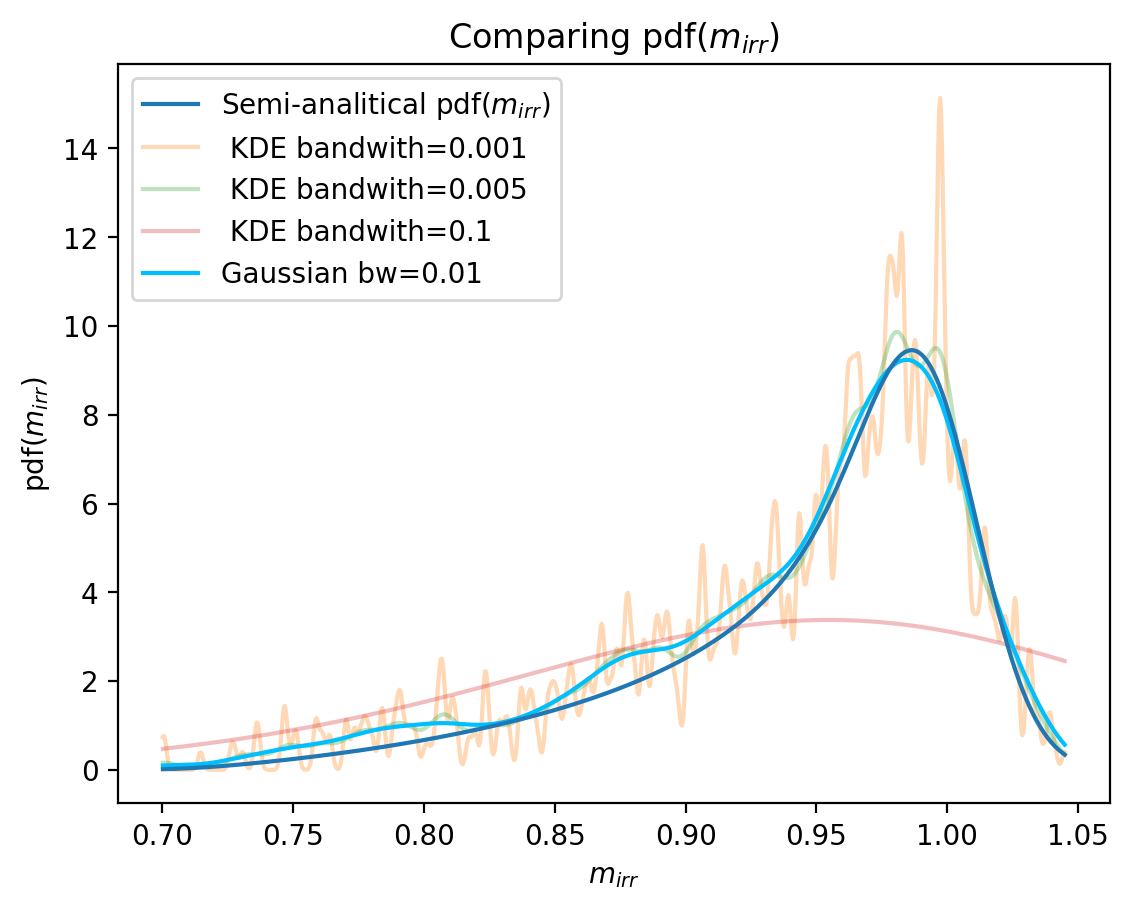

In [21]:
plt.plot(xgrid, Mirr1, label='Semi-analitical pdf($m_{irr}$)',zorder=5)  

for bandwith in tqdm([0.001,0.005,0.1]):
    kdepdf = kde_sklearn(mass_irr,bandwidth=bandwith,kernel="gaussian") #Complete

    plt.plot(xgrid,kdepdf,label=' KDE bandwith='+str(bandwith),zorder=0, alpha=0.3)

plt.plot(xgrid,PDFgaus, color='deepskyblue', label='Gaussian bw='f'{bandwidth4}',zorder=1,alpha=1) 

plt.xlabel('$m_{irr}$')
plt.ylabel('pdf($m_{irr}$)')
plt.title('Comparing pdf($m_{irr}$)')
plt.legend()
plt.show()